In [1]:
import h5py

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import corner
import bilby

In [2]:
#Loading Files

gw170817 = h5py.File('/home/abhi/Projects/Data from GW Events/GW170817_GWTC-1.hdf5','r')
result = bilby.result.read_in_result(filename='/home/abhi/Desktop/New_Fitting_Relations/Untitled Folder/Results_From_Cluster/sys_err_full_dist_result.json')

#Samples

lambda_0_0_samples = result.posterior['lambda_0_0']
mass1_detector_frame = gw170817['IMRPhenomPv2NRT_lowSpin_posterior']['m1_detector_frame_Msun']
mass2_detector_frame = gw170817['IMRPhenomPv2NRT_lowSpin_posterior']['m2_detector_frame_Msun']


In [3]:
(len(mass1_detector_frame))**(1/2)

89.87769467448528

In [4]:
#Histogram and Binning

mm1, bb1 = np.histogram(mass1_detector_frame, bins=20)
freq_mass_1 = mm1/np.sum(mm1)
bin_centers_freq_mass_1 = 0.5*(bb1[1:] + bb1[:-1])

mm2, bb2 = np.histogram(mass1_detector_frame, bins=100)
cum_freq_mass_1 = np.cumsum(mm2)/np.sum(mm2)
bin_centers_cum_freq_mass_1 = 0.5*(bb2[1:] + bb2[:-1])

m1_freq_interpolant  = sp.interpolate.interp1d(bin_centers_freq_mass_1, freq_mass_1, kind='cubic',
                                               fill_value=(0.,  0.), bounds_error=False)
m1_cum_freq_interpolant  = sp.interpolate.interp1d(bin_centers_cum_freq_mass_1, cum_freq_mass_1,
                                                   fill_value=(0,  1), bounds_error=False)

mm3, bb3 = np.histogram(mass2_detector_frame, bins=20)
freq_mass_2 = mm3/np.sum(mm3)
bin_centers_freq_mass_2 = 0.5*(bb3[1:] + bb3[:-1])

mm4, bb4 = np.histogram(mass2_detector_frame, bins=100)
cum_freq_mass_2 = np.cumsum(mm4)/np.sum(mm4)
bin_centers_cum_freq_mass_2 = 0.5*(bb4[1:] + bb4[:-1])

m2_freq_interpolant  = sp.interpolate.interp1d(bin_centers_freq_mass_2, freq_mass_2,
                                               fill_value=(0.,  0.), bounds_error=False)
m2_cum_freq_interpolant  = sp.interpolate.interp1d(bin_centers_cum_freq_mass_2, cum_freq_mass_2,
                                                   fill_value=(0.,  1), bounds_error=False)



hl00,bins = np.histogram(lambda_0_0_samples,bins=60)
frac_hl00 = hl00/np.sum(hl00)
bcsl00 = 0.5*(bins[:-1]+bins[1:])
chl00 = np.cumsum(hl00)/np.sum(hl00)



pdf_l00 = sp.interpolate.interp1d(bcsl00,frac_hl00,fill_value=(0.,0.),bounds_error=False,kind='cubic')
cdf_l00 = sp.interpolate.interp1d(bcsl00,chl00,fill_value=(0.,1.),bounds_error=False)

#Prior Class
class CustomPrior(bilby.prior.Prior):    
    def __init__(self, *args, **kwargs):
        """Prior using on masses.
        
        Notes
        -----
        First two arguments are `scipy.interpolate.interp1d`
        instances for the PDF and CDF of the mass posterior.
        samples.
        """
        interpolant_pdf, interpolant_cdf, *args = args

        kwargs['minimum'] = interpolant_pdf.x.min()
        kwargs['maximum'] = interpolant_pdf.x.max()

        self.interpolant_pdf = interpolant_pdf
        self.interpolant_cdf = interpolant_cdf

        super().__init__(*args, **kwargs)

    def prob(self, val):
        return self.interpolant_pdf(val)

    def ln_prob(self, val):
        return np.log(self.prob(val))

    def rescale(self, val):
        self.test_valid_for_rescaling(val)
        if not hasattr(val, 'size') or val.size==1:
            return self._rescale(val)
        else:
            return np.array(
                [self._rescale(v) for v in val]
            )
    def _rescale(self, val):
        try:
            res = sp.optimize.brentq(
                lambda z: self.interpolant_cdf(z) - val,
                self.minimum, self.maximum
            )
        except ValueError as e:  # pathological issue at the boundaries
            if e.__str__() != 'f(a) and f(b) must have different signs':
                raise
            res = np.random.uniform(self.minimum, self.maximum)
        return res

In [5]:
#Priors

lambda_0_0_prior = CustomPrior(pdf_l00,cdf_l00)
m1_prior = CustomPrior(m1_freq_interpolant, m1_cum_freq_interpolant)
m2_prior = CustomPrior(m2_freq_interpolant, m2_cum_freq_interpolant)

In [6]:
#Prior Dictionary for Bilby
prior_dictionary = dict(
    mass_1=CustomPrior(m1_freq_interpolant, m1_cum_freq_interpolant),
    mass_2=CustomPrior(m2_freq_interpolant, m2_cum_freq_interpolant),
    lambda_0_0 = CustomPrior(pdf_l00,cdf_l00),
    a_1=bilby.gw.prior.Uniform(name='a_1', minimum=0, maximum=0.05,
                               latex_label='$a_1$', unit=None, boundary=None),
    a_2=bilby.gw.prior.Uniform(name='a_2', minimum=0, maximum=0.05,
                               latex_label='$a_2$', unit=None, boundary=None),
    tilt_1=bilby.prior.Sine(name='tilt_1', latex_label='$\\theta_1$', unit=None),
    tilt_2=bilby.prior.Sine(name='tilt_2', latex_label='$\\theta_2$', unit=None),
    phi_12=bilby.gw.prior.Uniform(name='phi_12', minimum=0, maximum=2 * np.pi,
                                  boundary='periodic', latex_label='$\\Delta\\phi$', unit=None),
    phi_jl=bilby.gw.prior.Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi,
                                  boundary='periodic', latex_label='$\\phi_{JL}$', unit=None),
    luminosity_distance=bilby.gw.prior.UniformComovingVolume(name='luminosity_distance',
                                                             minimum=1, maximum=75, latex_label='$d_L$',
                                                             unit='Mpc', boundary=None),
    dec=bilby.prior.Cosine(name='dec', latex_label='$\\mathrm{DEC}$',
                           unit=None, minimum=-np.pi / 2, maximum=np.pi / 2, boundary=None),
    ra=bilby.gw.prior.Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic',
                              latex_label='$\\mathrm{RA}$', unit=None),
    theta_jn=bilby.prior.Sine(name='theta_jn', latex_label='$\\theta_{JN}$',
                              unit=None, minimum=0, maximum=np.pi, boundary=None),
    psi=bilby.gw.prior.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic',
                               latex_label='$\\psi$', unit=None)
)


bns_prior = bilby.gw.prior.BBHPriorDict(dictionary=prior_dictionary)

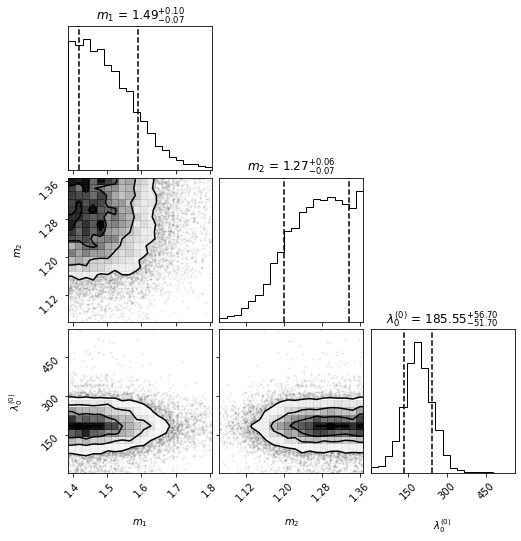

In [7]:
#Sample Plots
sample = bns_prior.sample(20000)

data_for_plot = np.column_stack([sample['mass_1'],sample['mass_2'],sample['lambda_0_0']])

figure = corner.corner(data_for_plot,quantiles=(0.16, 0.84),show_titles=True
                       ,labels = [r'$m_1$',r'$m_2$',r'$\lambda_0^{(0)}$'])
